# This script is for analyzing h5 files (Stalefish output)

The script has many functions but only four general purposes: 

1) read in h5 files 

2) add scaling either within-box, within-slice, or within-brain

3) interpolates data to scale size of slice (1d interps for curve cortex df.column.values / various methods for hand-drawn areas

4) combines brains within conditions and compares them across condition 

In [1]:
# you can get in the stalefish directory or wherever your files are,the directory of your data to read in the h5's
#cd Stalefish/ucr

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from matplotlib.patches import Polygon
import matplotlib as mpl
import pandas as pd


import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale,scale,normalize

from numpy import polyder
import skimage as sk
import math

import scipy as sc
from scipy import interpolate 


from skimage import measure 
from skimage import io
from skimage import feature
from skimage import filters

from skimage.morphology import medial_axis, skeletonize, skeletonize_3d
from skimage.morphology import skeletonize_3d
from skimage import data
from skimage.util import invert

from PIL import ImageFilter
from PIL import Image, ImageDraw

C:\Users\Mackenzie\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In the current state some of the functions are outside the classs and some of them are in the class. I think it would be best to either put all of the functions in or out of the class. 

Either way this all needs to be packaged up so users can just call functions 

In [3]:
# Within-Box Scaling
def single_scaling(box_frame):
    box_frame['box_std_dev'] = box_frame[0].std() 
    box_frame['box_z_score'] = (box_frame[0] - box_frame[0].mean()) / (box_frame[0].std())
    box_frame['box_min_max'] = minmax_scale(box_frame[0])
    box_frame['box_mean_center'] = scale(box_frame[0])
    box_frame['box_background_norm'] = box_frame[0] / background_level
    box_frame['box_signal_sum'] = np.array(box_frame[0])
    
    

# Within-Slice Scaling
def slice_scale(single_slice_data):
    raw_mean = single_slice_data.raw_mean
    single_slice_data['slice_min_max'] = minmax_scale(raw_mean)
    single_slice_data['slice_z_score'] = (raw_mean - raw_mean.mean()) / (raw_mean.std())
    single_slice_data['slice_mean_center'] = scale(raw_mean)
    single_slice_data['slice_background_norm'] = raw_mean / background_level
    # so you might want to get rid of the within-box mean_max now? 
    # keep in mind that the within-box scaling, is the mean of those min_max scaled within box
    return single_slice_data


In [4]:
class stalefish:
    def __init__(self,filename):
        self.filename = filename
        h5_file = h5py.File(filename)
        background_level = 10  #h5_file['something']['something'] #select a background level, this will be automated soon 
        print('Your file:',filename, 'has',list(h5_file['nframes']),'slices')
        print('if you would like to explore scaling options:')
        
        
    def box_scaling(self): 
        slice_list = list(h5_file)
        slice_list = slice_list[:-1] #get rid of nframes
        all_slices_df_list = []
        

        
        for a_slice in slice_list: #iterate through all slices in the h5
            this_slice = h5_file[a_slice]

            box_name_list = []
            box_mean_list = []
            z_score_mean_list_by_box = []  #empty lists to fill with adjusted mean values
            mean_box_min_max = []
            mean_background_division = []
            mean_box_from_h5 = []
            box_iter_name = []
            box_sum = []
            box_length = []

            bad_box_list = ['class', 'fitted', 'fitted_offset', 'fitted_rotated', 'means', 'means_autoscaled', 'nboxes',
                 'sbox_centers', 'sbox_linear_distance','sboxes']


            nboxes = list(h5_file[a_slice]['nboxes'])
            nbox_val = nboxes[0]
            box_count = 0
            
            for i in range(0,nbox_val): # iterate through all boxes of a single slice
            
                name_of_box = ('box{0}'.format(i)) 
            
                if name_of_box not in bad_box_list:  
                    this_box = (h5_file[a_slice])[name_of_box]
                    df_this_box = pd.DataFrame(np.array(this_box)) 
        
                    single_scaling(df_this_box) 
        
                    # this block of code fills up the empty lists above, making lists of all boxes which contain   
                    # the mean of a single way of scaling per box 
                    box_name_list.append(str(name_of_box))
                    box_mean_list.append(df_this_box[0].mean())
                    z_score_mean_list_by_box.append(df_this_box['box_z_score'].mean())
                    mean_box_min_max.append(df_this_box['box_min_max'].mean())
                    mean_background_division.append(df_this_box['box_background_norm'].mean())
                    box_sum.append(df_this_box['box_signal_sum'].sum())
                    box_length.append(len(df_this_box['box_signal_sum']))
                    box_iter_name.append(box_count)
                    box_count += 1
           
                    a = list(h5_file[a_slice]['means'])


            df_means_from_scaling = pd.DataFrame({'slice':str(a_slice),'box_name':box_name_list,'raw_mean':box_mean_list,
                                                  'z_score':z_score_mean_list_by_box,'min_max':mean_box_min_max,
                                                  'bckrnd_div':mean_background_division,
                                                  'box_number':box_iter_name,'box_sig_sum':box_sum,
                                                  'box_len':box_length}) #it doesn't look like means is in order?
    
            df_means_from_scaling['sbox_lin_dist'] = h5_file[a_slice]['sbox_linear_distance']
            #df_means_from_scaling['means'] = h5_file[a_slice]['means']
   
            # need to make a per-slice key that shows the background 
    
            all_slices_df_list.append(df_means_from_scaling)
        
            all_box_frames = pd.concat(all_slices_df_list)
        
        return all_box_frames
    
        
    # THEN WITHIN BRAIN 
        
        
    #def scale_hand_drawn_area(self):
        # or could make this its own class with other functions???/
    

# Load in your file and add within-box and within-slice scaling

In [5]:
#filename = 'V_Id2_1 _1.h5'
filename = '17_291.h5'
h5_file = h5py.File(filename)
background_level = .85

one_file = stalefish(filename)

one_file_scale = one_file.box_scaling() # This function will take a few minutes, as it is adding a lot of scaling options

slice_scale_frame = one_file_scale.groupby('slice').apply(slice_scale) # this one is quick however 

Your file: 17_291.h5 has [15] slices
if you would like to explore scaling options:


In [10]:
slice_scale_frame.head()

,bckrnd_div,box_len,box_name,box_number,box_sig_sum,min_max,raw_mean,slice,z_score,sbox_lin_dist,slice_min_max,slice_z_score,slice_mean_center,slice_background_norm,True_Order
0,205.282584,153,box0,0,26697.0,0.607843,174.490196,Frame001,-1.639937e-16,-0.495925,1.000000,2.365261,2.377177,205.282584,1
1,203.766462,134,box1,1,23209.0,0.585926,173.201493,Frame001,-1.275928e-16,-0.487077,0.980932,2.288070,2.299596,203.766462,1
2,195.387612,151,box2,2,25078.0,0.539571,166.079470,Frame001,2.073397e-16,-0.478229,0.875550,1.861470,1.870848,195.387612,1
3,187.025210,175,box3,3,27820.0,0.475665,158.971429,Frame001,4.390139e-16,-0.467287,0.770376,1.435707,1.442940,187.025210,1
4,175.747899,140,box4,4,20914.0,0.401255,149.385714,Frame001,3.473412e-16,-0.456557,0.628540,0.861536,0.865876,175.747899,1


# User needs to add in parameters which will allow for later combining of slices 

In [11]:
## STEP 1: RE-NAME THE SLICE ORDER FOR ALIGNMENT ###

from math import floor 
true_start_slice = 1 # this may be 2,3, or 4, and has to do with the alignment of all slices, look at original images to gain this info 
bin_number = 100
slice_scale_frame['True_Order'] = [true_start_slice + floor(i/bin_number) for i in range(len(slice_scale_frame))] 

In [12]:
### STEP 2: Clean the data ###
#Add some funtionality to just clean the data by removing bins that have splotches? 

In [13]:
### STEP 3: Run Interpolation ### THIS CODE WORKS GREAT FOR PLOTTING!! 

interp_list = ['slice_mean_center','slice_z_score','slice_min_max']

min_max_list = []

all_interped_df_list = []



# Groupby slices and get the min and max sbox linear distance for each slice
slice_groups = slice_scale_frame.groupby('True_Order').groups.keys()
for slices in slice_groups: 
    this_frame = slice_scale_frame.loc[slice_scale_frame['True_Order'] == slices]

    min_dist = this_frame.sbox_lin_dist.min()
    max_dist = this_frame.sbox_lin_dist.max()

    min_max_list.append((min_dist,max_dist))
    
    
    x = this_frame.sbox_lin_dist #this might just be a list of the sbox_lin_dist
    xnew = np.arange(min_dist,(max_dist - .01), .005) #so this is what needs to be standard amount across brains
    

    new_frame = pd.DataFrame({'slice':slices,'new_sbox_lin_dist':xnew})
    
    
    # interpolate each column to with x_values = new_sbox_lin_dist
    for column in interp_list: 
        this_column = this_frame[column] #this is where the interpolation will go? 
        this_column_name = 'interped_{0}'.format(column)
        

        y = this_column.values
        
        f = interpolate.interp1d(x,y)
        
        ynew = f(xnew)   
        

        new_frame[this_column_name] = ynew
  
    
    all_interped_df_list.append(new_frame)


    
all_interped_dfs = pd.concat(all_interped_df_list)

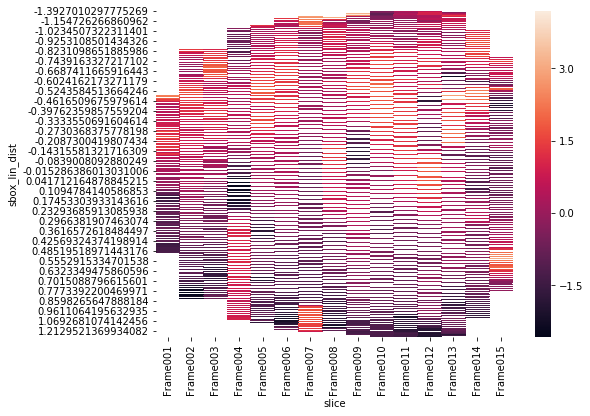

In [17]:
# Within-Slice (Mean Centering) NO INTERPOLATION
data_pivot = slice_scale_frame.pivot('sbox_lin_dist','slice','slice_mean_center')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)

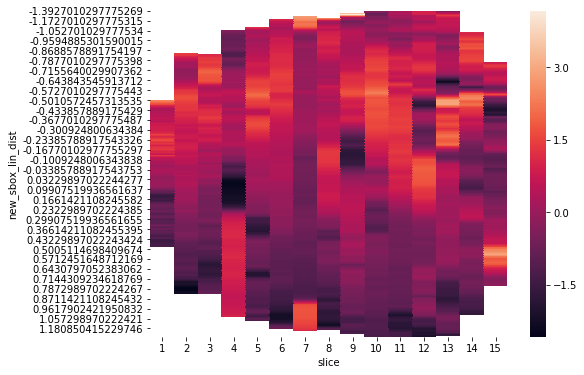

In [18]:
# Within-Slice (Mean Centering) WITH INTERPOLATION
data_pivot = all_interped_dfs.pivot('new_sbox_lin_dist','slice','interped_slice_mean_center')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)

In [ ]:
# Within-Slice (Mean Centering)
data_pivot = slice_scale_frame.pivot('sbox_lin_dist','slice','slice_mean_center')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)

Number of frames: 15
100


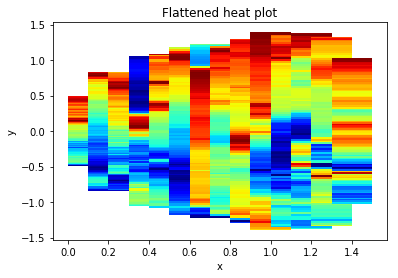

In [19]:
with h5py.File (filename, 'r') as f:
    #print("Keys: {0}".format(list(f.keys())))

    # It's a bit ugly, the way you get the value of the nframes
    # object; you have to convert the hdf5 object into a list, then
    # get the 0th value of the list (which always has one element)
    nf = list(f['/nframes'])[0]
    print ('Number of frames: {0}'.format(nf))

    # Empty lists to hold data. These'll be lists of lists
    x = []
    y = []
    means = []
    thicks = []

    for i in range(1,nf):

        # Create the 'frame tag' (e.g. 'Frame000')
        frame = 'Frame{0:03}'.format(i)

        # The means of the sampled boxes are in means or means_autoscaled
        key = '{0}/means_autoscaled'.format(frame)
        means_ = list(f[key])

        # The position on the 3D x-axis is in class/layer_x:
        key = '{0}/class/layer_x'.format(frame)

        # This creates a list with as many elements as there are
        # means, all with the same value (class/layer_x)
        x_ = list(f[key]) * len(means_)

        # For y values, use sbox_linear_distance
        key = '{0}/sbox_linear_distance'.format(frame)
        y_ = list(f[key])
     
        # Use the per-frame slice thickness when plotting rectangular polygons
        key = '{0}/class/thickness'.format(frame)
        thicks_ = list(f[key]) * len(means_)

        # Now have four lists, x_, y_, means_ and thicks_. These can
        # be appended onto the 'lists of lists' for all slices.
        x.append(x_)
        y.append(y_)
        means.append(means_)
        thicks.append(thicks_)

    print(len(y_))
    # We now have (as lists of lists) x, y, means and the thicknesses
    # (in dimension x) of all the boxes. A regular scatter graph gives
    # awful results. Instead, plot each x/y as a rectangle with colour
    # given by means.
    plt.title('Flattened heat plot')
    for ii in range(0,len(x)): # len(x) is the number of frames.
        # Within each frame, make polygons
        x_l = np.array(x[ii])
        x_r = np.add (np.array(x[ii]), np.array(thicks[ii]))
        y_ar = np.array(y[ii]) # convert the list y[ii] into a np array
        y_t = y_ar + (shift(y_ar, -1, cval=y_ar[-1]) - y_ar) / 2.0 # half way between y and the next y
        y_b = y_ar - (y_ar - shift(y_ar, 1, cval=y_ar[0])) / 2. # half way between y and the previous y

        for jj in range(0,len(x[ii])): # len(x[ii]) is the number of bins in a frame
            # Boxes have vertices: (x_l,y_b) -> (x_r,y_b) -> (x_r,y_t) -> (x_l,y_t)
            v = np.array([ [ x_l[jj], y_b[jj] ], # v stands for 'vertices'
                           [ x_r[jj],  y_b[jj] ],
                           [ x_r[jj], y_t[jj] ],
                           [ x_l[jj], y_t[jj] ] ])
            poly = Polygon (v, facecolor=mpl.cm.jet(means[ii][jj]), edgecolor='None')
            plt.gca().add_patch(poly)


    plt.xlabel('x')
    plt.ylabel('y')
    plt.autoscale()
    plt.show()

# Try out some different within-box or within-slice scaling methods

Keep in mind that we have stored sbox_linear_values, so regenerating the true length of the slices is still possible!! 

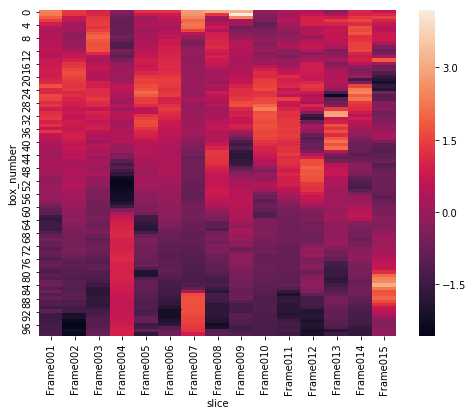

In [20]:
# Within-Slice (Mean Centering)
data_pivot = slice_scale_frame.pivot('box_number','slice','slice_mean_center')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)

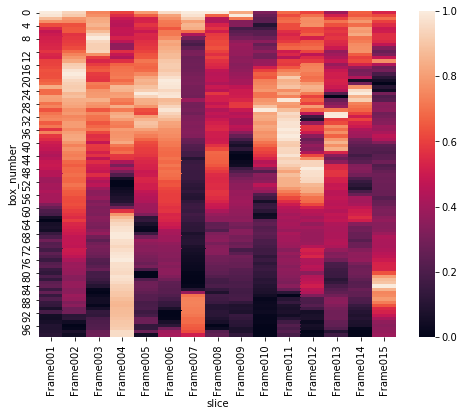

In [21]:
# Within-Slice (Min Max Scaling)
data_pivot = slice_scale_frame.pivot('box_number','slice','slice_min_max')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)

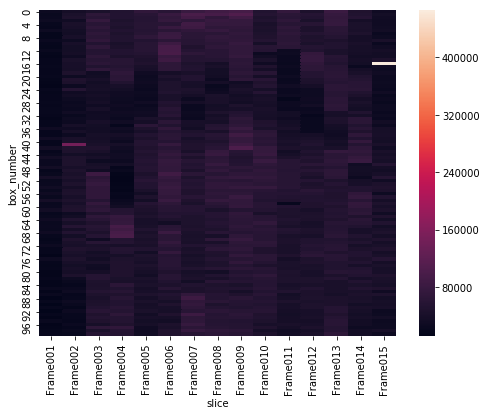

In [22]:
# Within-Box (Signal Sum)
data_pivot = one_file_scale.pivot('box_number','slice','box_sig_sum')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)

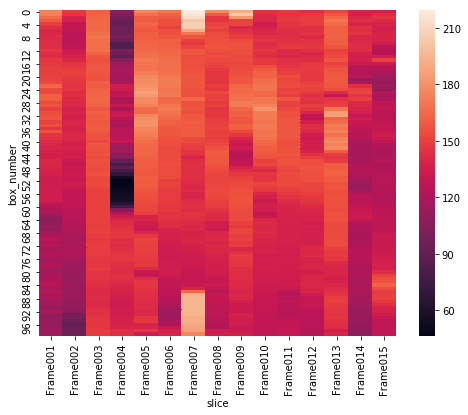

In [23]:
# Within-Box (Raw Mean of Box)
data_pivot = one_file_scale.pivot('box_number','slice','raw_mean')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)

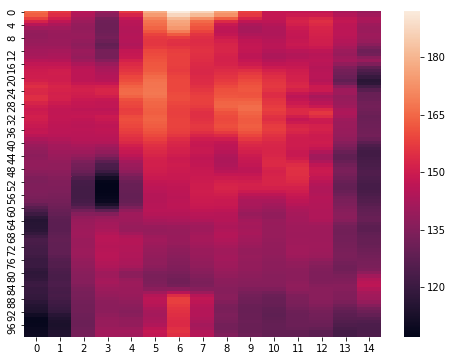

In [24]:
# If you cared to Gaussian your heat-map, but this looks to be happening along the columns not the rows
# You could also just use convolve to blur, as scipy.ndimage.convolve
#  see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html#scipy.ndimage.convolve

from scipy.ndimage import gaussian_filter
data_pivot_blur = gaussian_filter(data_pivot, sigma=.9) #compare to one directly above (raw mean top vs blurred mean here)
plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot_blur)